### Описание исходного набора данных

В качестве набора данных был взят [Vehicle Sales Data](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data/data), содержащий данные о продажах автомобилей и состоящий из следующих полей:

- year. Год производства автомобиля
- make. Брэнд автомобиля
- model. Модель автомобиля
- trim. Дополнение к модели автомобиля
- body. Тип двигателя
- transmission. Тип трансмиссии
- vin. ВИН номер
- state. Штат, где двигатель зарегистрирован
- condition. Состояние двигателя на момент продажи
- odometer. Значение на одометре машины перед продажей (пробег автомобиля)
- color. Цвет автомобиля
- interior. Цвет интерьера автомобиля
- seller. Продавец автомобиля
- mmr. Manheim Market Report. Может показывать рыночную цену автомобиля
- sellingprice. Цена, за которую продали автомобиль
- saledate. Дата и время, когда продали автомобиль

### Импорт библиотек

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.2 MB/s eta 0:00:00


In [2]:
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

### Загрузка датасета

In [3]:
initial_data = pd.read_csv("https://raw.githubusercontent.com/mansurik1/MMO2025_works/refs/heads/master/lw2/datasets/car_prices/car_prices.csv")

In [4]:
# Размер датасета
initial_data.shape

(558837, 16)

Изначальный датасет слишком большой. Сделаем подвыборку на 25 000 записей

In [5]:
# Создание нового датасета поменьше
data = initial_data.sample(25000, random_state=8)

data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
363218,2008,Mercury,Milan,Premier,Sedan,automatic,3mehm021x8r636447,ny,28.0,84302.0,black,beige,wheels r us inc,6125.0,7000.0,Wed Feb 25 2015 03:30:00 GMT-0800 (PST)
3460,2007,Ford,Fusion,SE,Sedan,automatic,3fahp07z07r258408,ca,2.0,151270.0,black,black,repo remarketing/patelco credit union,2700.0,1000.0,Wed Dec 17 2014 11:00:00 GMT-0800 (PST)
508202,2014,Kia,Rio,LX,sedan,automatic,knadm4a38e6340309,nv,43.0,36563.0,white,beige,enterprise veh exchange/rental,9700.0,10000.0,Fri Jun 12 2015 05:00:00 GMT-0700 (PDT)
472373,2013,Ford,Escape,SEL,suv,automatic,1fmcu0hxxdud23355,il,44.0,19503.0,brown,black,ford motor credit company llc,18850.0,18900.0,Tue Jun 02 2015 04:00:00 GMT-0700 (PDT)
273509,2013,Mercedes-Benz,C-Class,C250 Sport,Sedan,automatic,wddgf4hb1da816103,ca,29.0,17151.0,white,beige,mercedes-benz financial services,23300.0,22250.0,Thu Feb 12 2015 04:30:00 GMT-0800 (PST)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 363218 to 210765
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          25000 non-null  int64  
 1   make          24541 non-null  object 
 2   model         24538 non-null  object 
 3   trim          24528 non-null  object 
 4   body          24404 non-null  object 
 5   transmission  22121 non-null  object 
 6   vin           25000 non-null  object 
 7   state         25000 non-null  object 
 8   condition     24473 non-null  float64
 9   odometer      24994 non-null  float64
 10  color         24965 non-null  object 
 11  interior      24965 non-null  object 
 12  seller        25000 non-null  object 
 13  mmr           25000 non-null  float64
 14  sellingprice  25000 non-null  float64
 15  saledate      25000 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 3.7+ MB


In [7]:
# Нулевые значения в наборе данных
data.isnull().sum()

,0
year,0
make,459
model,462
trim,472
body,596
transmission,2879
vin,0
state,0
condition,527
odometer,6


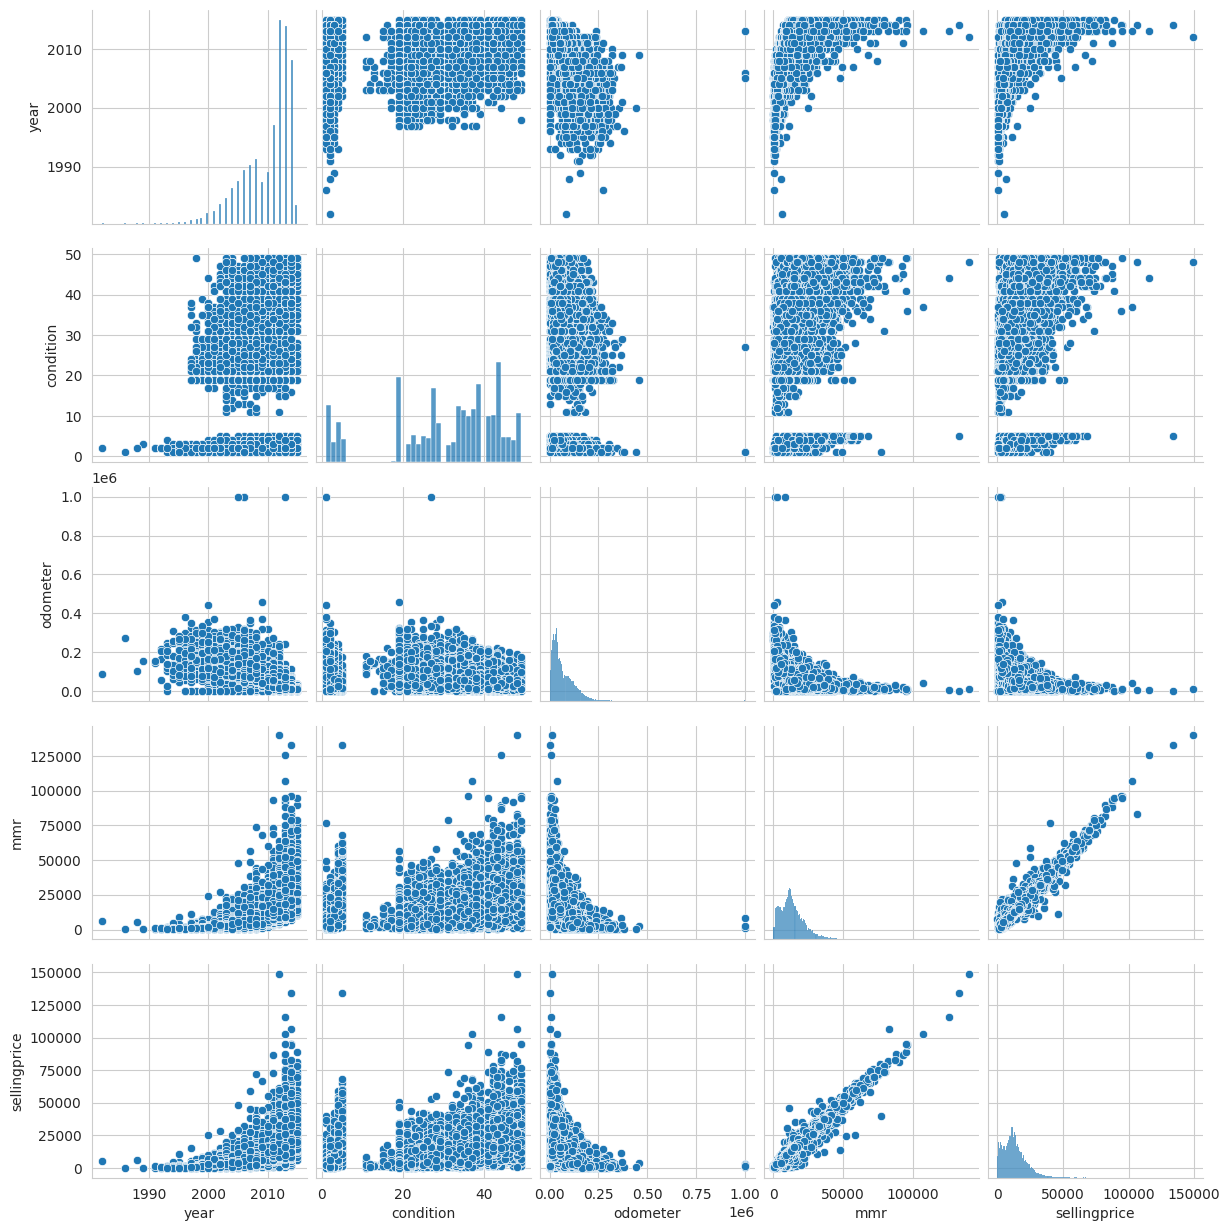

In [8]:
sns.pairplot(data)
plt.show()

### Устранение пропусков

Первым делом разберёмся с пропусками в числовых признаках, т. к. оных с пропусками гораздо меньше, чем категориальных.

In [9]:
# Количество пропусков в числовых колонках в %
numbers_missing_cols = ["condition", "odometer"]

for column in numbers_missing_cols:
    print(f" Пропусков в колонке {column}: {data[column].isnull().sum()/data[column].size* 100} %")

 Пропусков в колонке condition: 2.108 %
 Пропусков в колонке odometer: 0.024 %


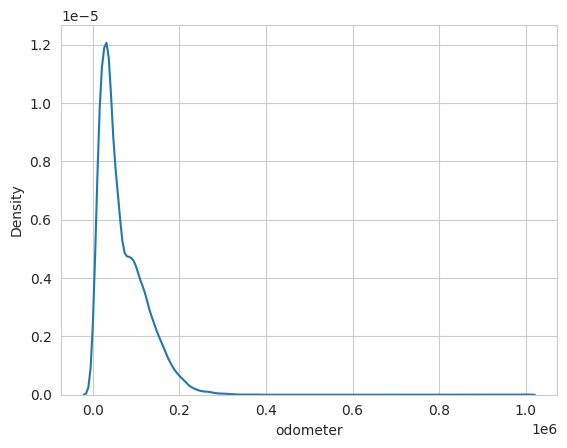

In [10]:
sns.kdeplot(data=data, x="odometer")
plt.show()

In [11]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

In [12]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))

    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))

    new_df = pd.DataFrame({'Исходные данные':original_data})

    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data

    sns.kdeplot(data=new_df)

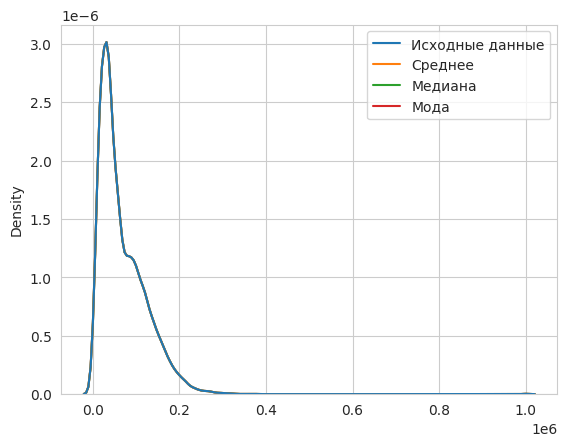

In [13]:
# Различные стратегии заполнения для признака odometer
research_impute_numeric_column(data, "odometer")

Стратегия заполнения признака odometer не имеет значения, так как пропусков слишком мало. Заполним пропущенные значения модой

In [14]:
# Заполнение пустых значений в поле odometer
data_filled = data.copy().reset_index(drop=True)
data_filled["odometer"], _, _ = impute_column(data_filled, "odometer", strategy_param='most_frequent')

data_filled["odometer"].isnull().sum()

np.int64(0)

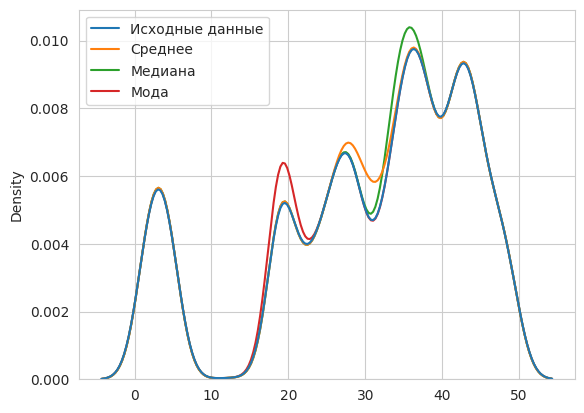

In [15]:
# Различные стратегии заполнения для признака condition
research_impute_numeric_column(data, "condition")

Признак condition предлагаю заполнить с помощью KNN.

In [16]:
# Список колонок, которые будут участвовать в KNNInpute
knnimpute_cols = numbers_missing_cols + ["year", "mmr"]
knnimpute_cols

['condition', 'odometer', 'year', 'mmr']

In [17]:
# До вставки значений
knnimpute_df = data_filled[knnimpute_cols].copy()
knnimpute_df.isnull().sum()

,0
condition,527
odometer,0
year,0
mmr,0


In [18]:
# Создание импютера и вставка пропущенных значений
knnimputer = KNNImputer(
    n_neighbors=5,
    weights='distance',
    metric='nan_euclidean',
    add_indicator=False,
)
knnimpute_df_imputed_temp = knnimputer.fit_transform(knnimpute_df)
knnimpute_df_imputed = pd.DataFrame(knnimpute_df_imputed_temp, columns=knnimpute_df.columns)

In [19]:
# После вставки значений
knnimpute_df_imputed.isnull().sum()

,0
condition,0
odometer,0
year,0
mmr,0


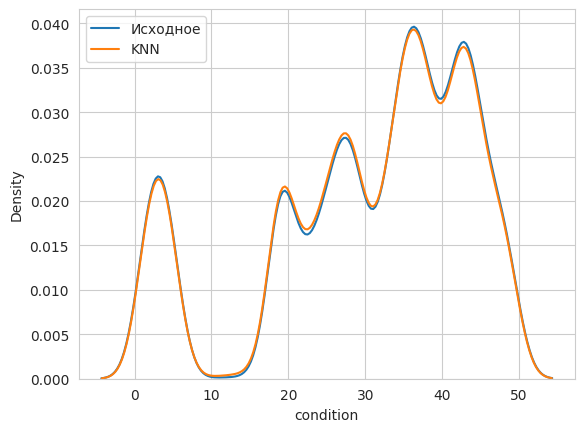

In [20]:
# KDE до заполнения пропусков и после
sns.kdeplot(data=data_filled, x="condition", label="Исходное")
sns.kdeplot(data=knnimpute_df_imputed, x="condition", label="KNN")
plt.legend()
plt.show()

In [21]:
# Применение импьютации
data_filled["condition"] = knnimpute_df_imputed["condition"].astype("float64")
data_filled["condition"].isnull().sum()

np.int64(0)

Теперь будем разбираться с категориальными признаками

In [22]:
# Количество пропусков в категориальных колонках в %
cat_missing_cols = ["make", "model", "trim", "body", "transmission", "color", "interior"]

for column in cat_missing_cols:
    print(f" Пропусков в колонке {column}: {data[column].isnull().sum()/data[column].size* 100:.3f} %")

 Пропусков в колонке make: 1.836 %
 Пропусков в колонке model: 1.848 %
 Пропусков в колонке trim: 1.888 %
 Пропусков в колонке body: 2.384 %
 Пропусков в колонке transmission: 11.516 %
 Пропусков в колонке color: 0.140 %
 Пропусков в колонке interior: 0.140 %


In [23]:
# Количество уникальных значений в колонках
for column in cat_missing_cols:
    print (f"Количество уникальных значений в колонке {column}: {len((data_filled[column].value_counts()))}")

Количество уникальных значений в колонке make: 73
Количество уникальных значений в колонке model: 658
Количество уникальных значений в колонке trim: 989
Количество уникальных значений в колонке body: 62
Количество уникальных значений в колонке transmission: 2
Количество уникальных значений в колонке color: 19
Количество уникальных значений в колонке interior: 17


Предлагаю удалить строки с пропущенными значениями  во всех признаках, кроме transmition. Также проверим насколько в процентах уменьшилась входная выборка

In [24]:
data_filled_cat = data_filled.dropna(subset=["make", "model", "trim", "body", "color", "interior"])

for column in cat_missing_cols:
    print(f" Пропусков в колонке {column}: {data_filled_cat[column].isnull().sum()/data[column].size* 100:.3f} %")

 Пропусков в колонке make: 0.000 %
 Пропусков в колонке model: 0.000 %
 Пропусков в колонке trim: 0.000 %
 Пропусков в колонке body: 0.000 %
 Пропусков в колонке transmission: 11.120 %
 Пропусков в колонке color: 0.000 %
 Пропусков в колонке interior: 0.000 %


In [25]:
# Уменьшение размера выборки в процентах
(data.shape[0] - data_filled_cat.shape[0])/data.shape[0]*100

2.528

Исходный набор данных уменьшился на 2,5 %, поэтому удаление пустых значений можно считать допустимым.

Теперь разберёмся с признаком transmission

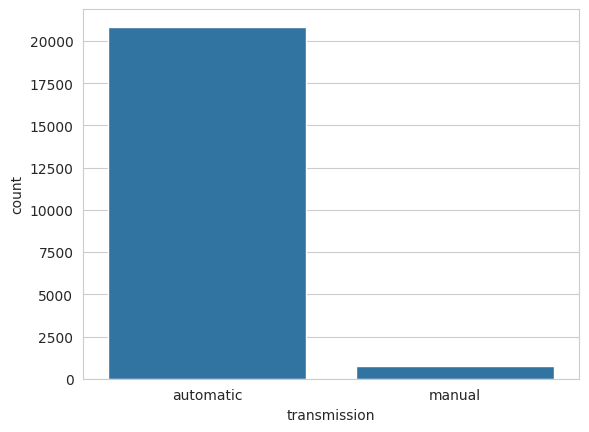

In [26]:
sns.countplot(data=data_filled_cat, x="transmission")
plt.show()

У столбца transmission всего два уникальных значений, причём одно из них встречается в датасете намного чаще другого. Чтобы не увеличивать данный разрыв предлагаю добавить ещё одно значение (категорию) — unknown.

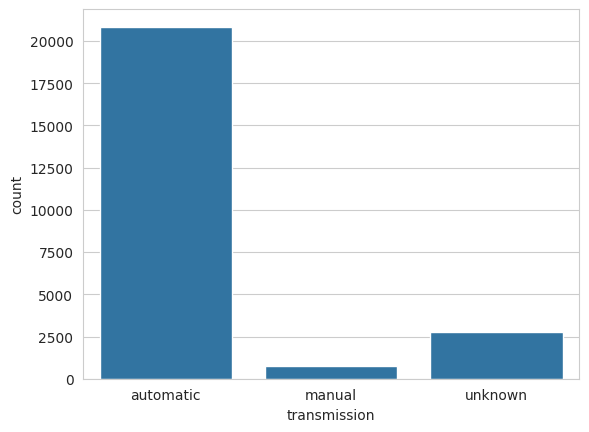

In [27]:
# Заполнение признака transmission
data_filled_cat.loc[:,"transmission"], _, _ = impute_column(data_filled_cat, "transmission", strategy_param="constant", fill_value_param="unknown")

sns.countplot(data=data_filled_cat, x="transmission")
plt.show()

In [28]:
# Проверка отсутствия нулевых значений
data_filled_cat.isnull().sum()

,0
year,0
make,0
model,0
trim,0
body,0
transmission,0
vin,0
state,0
condition,0
odometer,0


### Кодирование категориальных признаков

In [29]:
# Количество уникальных значений в колонках
for column in cat_missing_cols + ["vin", "state", "seller", "saledate"]:
    print (f"Количество уникальных значений в колонке {column}: {len((data_filled_cat[column].value_counts()))}")

Количество уникальных значений в колонке make: 48
Количество уникальных значений в колонке model: 604
Количество уникальных значений в колонке trim: 911
Количество уникальных значений в колонке body: 62
Количество уникальных значений в колонке transmission: 3
Количество уникальных значений в колонке color: 19
Количество уникальных значений в колонке interior: 17
Количество уникальных значений в колонке vin: 24345
Количество уникальных значений в колонке state: 37
Количество уникальных значений в колонке seller: 3746
Количество уникальных значений в колонке saledate: 1917


Обработаем категориальные признаки следующим образом:

1. Удалим столбец с vin, так как для каждой строки он уникален, то есть не несёт полезной информации
2. Преобразуем saledate в datetime
3. Закодируем transmission с помощью OHE
4. Все остальные категориальные признаки закодируем с помощью Frequency Encoder-а

In [30]:
# Первые два пункта
data_coded = data_filled_cat.copy()
data_coded = data_coded.drop(columns=["vin"])
data_coded["saledate"] = pd.to_datetime(data_coded["saledate"], format='mixed', utc=True)

data_coded.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2008,Mercury,Milan,Premier,Sedan,automatic,ny,28.0,84302.0,black,beige,wheels r us inc,6125.0,7000.0,2015-02-24 19:30:00+00:00
1,2007,Ford,Fusion,SE,Sedan,automatic,ca,2.0,151270.0,black,black,repo remarketing/patelco credit union,2700.0,1000.0,2014-12-17 03:00:00+00:00
2,2014,Kia,Rio,LX,sedan,automatic,nv,43.0,36563.0,white,beige,enterprise veh exchange/rental,9700.0,10000.0,2015-06-11 22:00:00+00:00
3,2013,Ford,Escape,SEL,suv,automatic,il,44.0,19503.0,brown,black,ford motor credit company llc,18850.0,18900.0,2015-06-01 21:00:00+00:00
4,2013,Mercedes-Benz,C-Class,C250 Sport,Sedan,automatic,ca,29.0,17151.0,white,beige,mercedes-benz financial services,23300.0,22250.0,2015-02-11 20:30:00+00:00


In [31]:
# Применение OHE для transmission
ce_OHE = OneHotEncoder(cols=["transmission"])
data_coded = ce_OHE.fit_transform(data_coded)
data_coded.head()

,year,make,model,trim,body,transmission_1,transmission_2,transmission_3,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2008,Mercury,Milan,Premier,Sedan,1,0,0,ny,28.0,84302.0,black,beige,wheels r us inc,6125.0,7000.0,2015-02-24 19:30:00+00:00
1,2007,Ford,Fusion,SE,Sedan,1,0,0,ca,2.0,151270.0,black,black,repo remarketing/patelco credit union,2700.0,1000.0,2014-12-17 03:00:00+00:00
2,2014,Kia,Rio,LX,sedan,1,0,0,nv,43.0,36563.0,white,beige,enterprise veh exchange/rental,9700.0,10000.0,2015-06-11 22:00:00+00:00
3,2013,Ford,Escape,SEL,suv,1,0,0,il,44.0,19503.0,brown,black,ford motor credit company llc,18850.0,18900.0,2015-06-01 21:00:00+00:00
4,2013,Mercedes-Benz,C-Class,C250 Sport,Sedan,1,0,0,ca,29.0,17151.0,white,beige,mercedes-benz financial services,23300.0,22250.0,2015-02-11 20:30:00+00:00


In [32]:
# Применение Frequency Encoder для остальных категориальных признаков
ce_Freq = CountEncoder(cols=data_coded.select_dtypes(include="object").columns, normalize=True)
data_coded = ce_Freq.fit_transform(data_coded)
data_coded.head()

,year,make,model,trim,body,transmission_1,transmission_2,transmission_3,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2008,0.003324,0.000328,0.001067,0.365931,1,0,0,0.010382,28.0,84302.0,0.200714,0.110062,0.000041,6125.0,7000.0,2015-02-24 19:30:00+00:00
1,2007,0.172234,0.023966,0.081254,0.365931,1,0,0,0.133249,2.0,151270.0,0.200714,0.443697,0.000041,2700.0,1000.0,2014-12-17 03:00:00+00:00
2,2014,0.033158,0.002544,0.038862,0.079777,1,0,0,0.022406,43.0,36563.0,0.187008,0.110062,0.011367,9700.0,10000.0,2015-06-11 22:00:00+00:00
3,2013,0.172234,0.022735,0.017236,0.042392,1,0,0,0.042310,44.0,19503.0,0.010547,0.443697,0.033897,18850.0,18900.0,2015-06-01 21:00:00+00:00
4,2013,0.029670,0.008495,0.002298,0.365931,1,0,0,0.133249,29.0,17151.0,0.187008,0.110062,0.009603,23300.0,22250.0,2015-02-11 20:30:00+00:00


### Нормализация числовых признаков

В данном разделе мы рассмотрим три варианта нормализация для поля odometer: логарифм, преобразование Бокса-Кокса, преобразование Йео-Джонсона

In [33]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=variable, bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

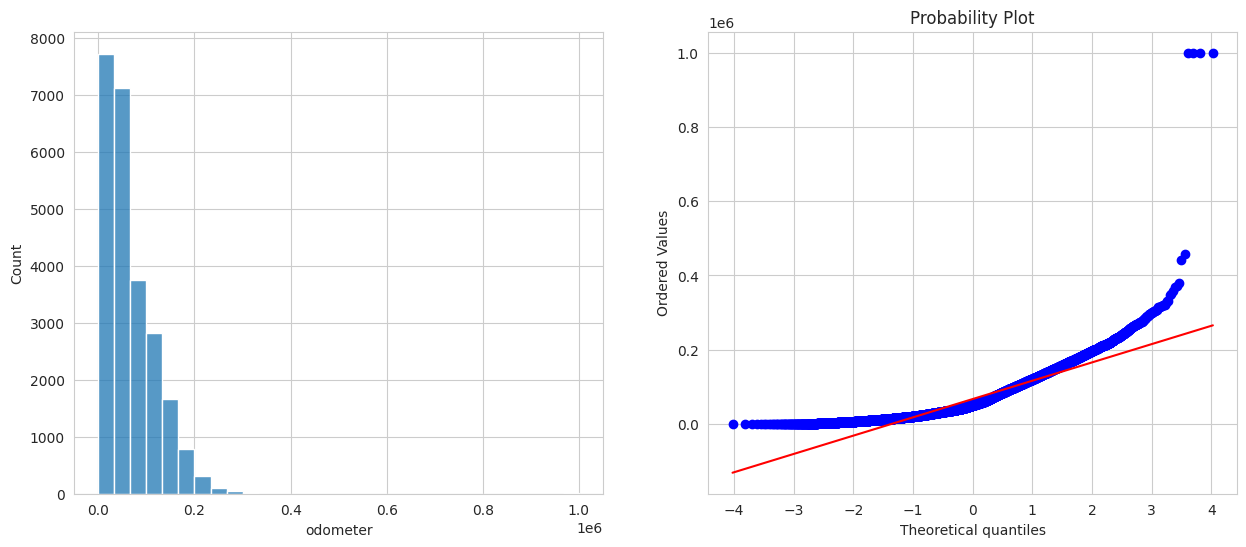

In [34]:
# Исходные данные
diagnostic_plots(data_coded, "odometer")

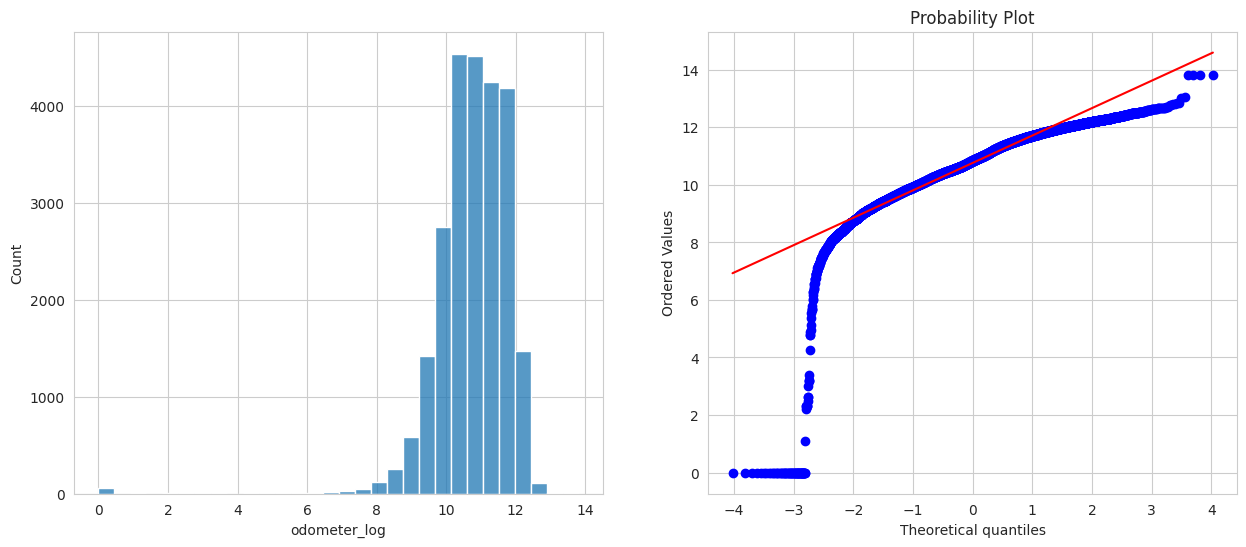

In [35]:
# Логарифмическое преобразование
data_coded_norm = data_coded.copy()
data_coded_norm["odometer_log"] = np.log(data_coded_norm["odometer"])
diagnostic_plots(data_coded_norm, "odometer_log")

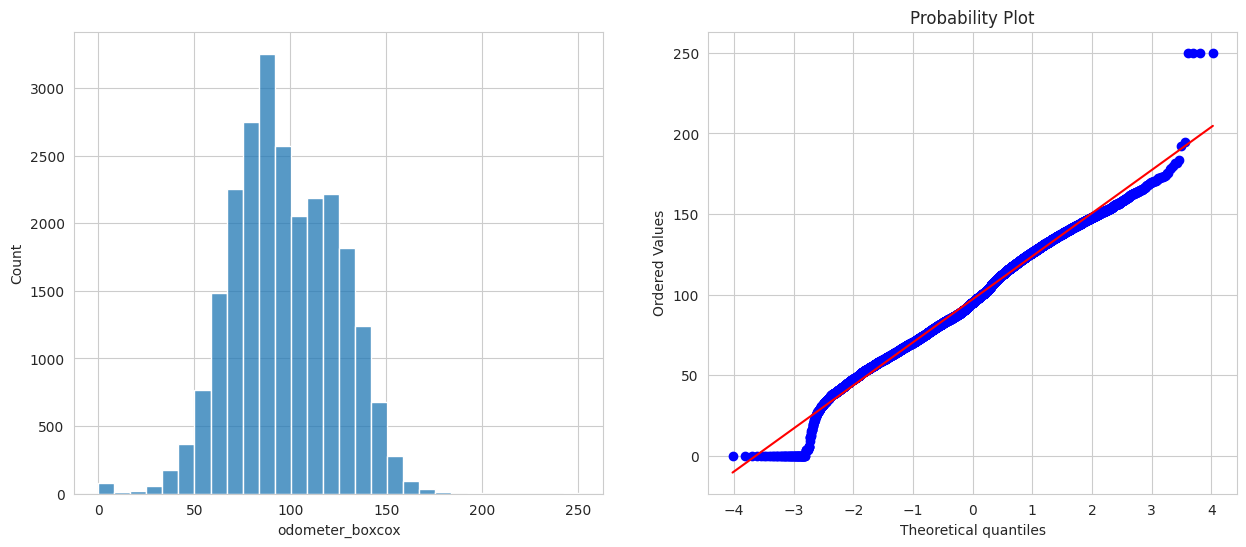

In [36]:
# Преобразование Бокса-Кокса
data_coded_norm["odometer_boxcox"], param_boxcox = stats.boxcox(data_coded_norm["odometer"])
diagnostic_plots(data_coded_norm, "odometer_boxcox")

In [37]:
param_boxcox

np.float64(0.31759895916371333)

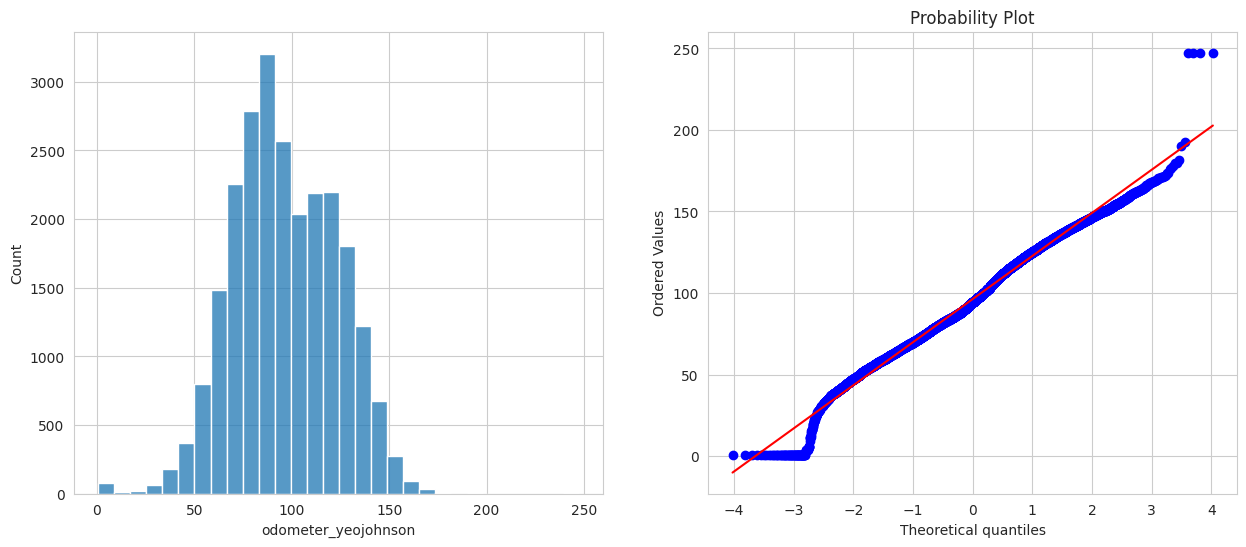

In [38]:
# Преобразование Йео-Джонсона
data_coded_norm["odometer_yeojohnson"], param_yeojohnson = stats.yeojohnson(data_coded_norm["odometer"])
diagnostic_plots(data_coded_norm, "odometer_yeojohnson")

In [39]:
param_yeojohnson

np.float64(0.31654043661503306)